### Disclaimer!
This is the very first version of the model, where the input data contains emojis.

Therefore, the model works terribly on text that doesn't contain the relevant emojis!

In [1]:
import os
import pickle
import numpy as np
import re

## Load dataset

In [4]:
target_names = ['😍','😡'] #['😍','😜','😭','😡']

numTweets = 500
data = []
filenames = []
for keyword in target_names:
    fullfile = os.path.expanduser("~/Dropbox/insight_datadir/500group/"+'outfile'+keyword)
    with open(fullfile, 'rb') as fp:
        itemlist = pickle.load(fp)
        data = data + itemlist
        filenames = filenames + [fullfile]

In [29]:
# numTargets = len(target_names)
# arr = np.ones((numTweets,), dtype=int)

# target = []
# numEmojis = len(target_names)
# for ii in range(numEmojis):
#     target = np.concatenate((target, arr*ii), axis=0).astype(int)

In [31]:
numEmojis = len(target_names)
arr = []
for i in range(numEmojis):
    arr.extend([i] * numTweets)
arr = np.array(arr, dtype=int)

In [33]:
target.shape

(1000,)

In [15]:
#print(re.findall(r'[@]\S*', itemlist[:10])) # Twitter user names
#print(re.findall(r'[RT]\S*', str)) # "RT"
#print(re.findall(r'[http]\S*', str)) # "RT"

### Format Tweet dataset


In [34]:
# this is like a struct
class tweet_train:
    pass

T = tweet_train()
T.target_names = target_names
T.data = data
T.filenames = filenames
T.target = target


In [35]:
T.target_names

['😍', '😡']

In [36]:
T.target[0]

0

In [37]:
print("\n".join(T.data[0].split("\n")[:3]))

@singularihoe What was that last song? But why jhope look like wanna fight with yoongs n joons🤣😍🤣💜


In [38]:
print(T.target_names[T.target[0]])

😍


In [39]:
for t in T.target[:3]:
...     print(T.target_names[t])

😍
😍
😍


### Tokenizing text with scikit-learn

In [40]:
# # load pre-trained word2vec model (from Twitter data, glove.twitter.27B.zip)
# fdir = fullfile = os.path.expanduser("~/Documents/glovetwitter27B/glovetwitter27B25d.txt")

# with open(fdir, "rb") as lines:
#     w2v = {line.split()[0]: np.array(map(float, line.split()[1:]))
#            for line in lines}

In [41]:
# tokenize
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(max_df=0.95, min_df=2,
                            max_features=100,
                            stop_words='english')
X_train_counts = count_vect.fit_transform(T.data)
X_train_counts.shape

(1000, 100)

In [42]:
count_vect.vocabulary_.get(u'algorithm')

### From occurrences to frequencies

In [43]:
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
X_train_tf.shape

(1000, 100)

In [44]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(1000, 100)

## Training a classifier

In [45]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, T.target)

In [46]:
# Split the dataset in training and test set:
from sklearn.model_selection import train_test_split
docs_train, docs_test, y_train, y_test = train_test_split(
    T.data, T.target, test_size=0.5)

In [47]:
# TASK: Build a vectorizer that splits strings into sequence of 1 to 3
# characters instead of word tokens
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 3), analyzer='char',
                             use_idf=False)

In [48]:
from sklearn.linear_model import Perceptron
from sklearn.pipeline import Pipeline
# TASK: Build a vectorizer / classifier pipeline using the previous analyzer
# the pipeline instance should stored in a variable named clf
clf = Pipeline([
    ('vec', vectorizer),
    ('clf', Perceptron(tol=1e-3)),
])

In [49]:
# TASK: Fit the pipeline on the training set
clf.fit(docs_train, y_train)

Pipeline(memory=None,
     steps=[('vec', TfidfVectorizer(analyzer='char', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
   ..._jobs=1, penalty=None, random_state=0,
      shuffle=True, tol=0.001, verbose=0, warm_start=False))])

In [50]:
# TASK: Predict the outcome on the testing set in a variable named y_predicted
y_predicted = clf.predict(docs_test)

In [51]:
# Print the classification report
from sklearn import metrics
print(metrics.classification_report(y_test, y_predicted,
                                    target_names=T.target_names))

             precision    recall  f1-score   support

          😍       0.92      0.97      0.95       253
          😡       0.97      0.92      0.94       247

avg / total       0.94      0.94      0.94       500



In [52]:
# Plot the confusion matrix
cm = metrics.confusion_matrix(y_test, y_predicted)
print(cm)

[[245   8]
 [ 20 227]]


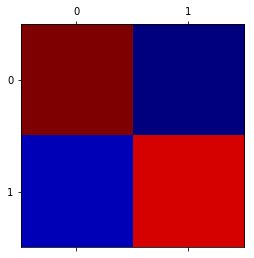

In [58]:
import matplotlib.pyplot as plt
plt.matshow(cm, cmap=plt.cm.jet)
plt.show()

In [56]:
# Predict the result on some short new sentences:
sentences = [
    u'Last Checkpoint: Last Thursday at 11:59 PM',
    u'Hate speech is a communication that carries no meaning other than the expression of hatred for some group',
    u'amazing wow love this!!!',
]
predicted = clf.predict(sentences)

In [57]:
print(predicted)

[0 1 0]
